## Prediction

In [ ]:
import pandas as pd
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    make_scorer,
)
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

from src.data.load_data import load_sample_train_test
from src.data.preprocessing import preprocess
from src.training.cv_strategy import strategie_evaluation
from src.training.evaluation import evaluate_model
from src.utils.misc import init_notebook
from src.utils.save import save_model

In [ ]:
n_jobs = -1  # pour le parallélisme
init_notebook()

## Stratégie d'évaluation

On se propose d'utiliser une StratifiedKFold : 
- on utilise la cross-validation (plus fiable que le train/test split)
- on utilise la stratégie KFold (plusieurs passes sur le jeu de données donc une estimation plus fiable)
- on mélange aléatoirement les données ("shuffle") pour éviter un éventuel tri des données initiales (ce qui induirait un fort biais, les données $i$ et $i+1$ pourraient être corrélées si elles étaient triées, et chaque fold pourrait n'être confronté qu'à une seule classe au lieu des 10 dans le pire des cas)
- c'est une méthode très adaptée à un jeu de données avec plusieurs classes : en effet, la version stratifiée permet de respecter la répartition des classes, ce qui est d'autant plus utile que les classes sont déséquilibrées. Ici les classes sont équilibrées donc l'avantage est moindre mais la version stratifiée est théoriquement meilleure.

In [ ]:
kfold = strategie_evaluation(n_splits=10)

### Métrique

Nous proposons d'utiliser l'accuracy.

### Création du x et du y

In [ ]:
x_train, x_test, y_train, y_test = load_sample_train_test()

In [ ]:
x_train = preprocess(x_train)
x_test = preprocess(x_test)

#### Evaluation des modèles

## 1ers modèles (hyper-paramètres par défaut)

Nous allons tester 2 modèles :
- Extra Trees (non vu en cours)
- Random Forest (vu en cours)

Puis nous allons optimiser les hyper-paramètres sur le Random Forest

### Extra Trees (ET)

In [ ]:
et = ExtraTreesClassifier(n_jobs=n_jobs, random_state=0)

temps de calcul 0.21 s
accuracy = 0.8377926421404682
f1_score = [0.82608696 0.84444444 0.89361702 0.63414634 0.75       0.93877551
 0.86956522 0.68085106 0.91304348 0.7804878  0.75555556 0.86956522
 0.86956522 0.68085106 0.78431373 0.83333333 0.79069767 0.77272727
 0.88888889 0.93877551 0.91666667 1.         0.8        0.91304348
 0.86792453 0.91304348]


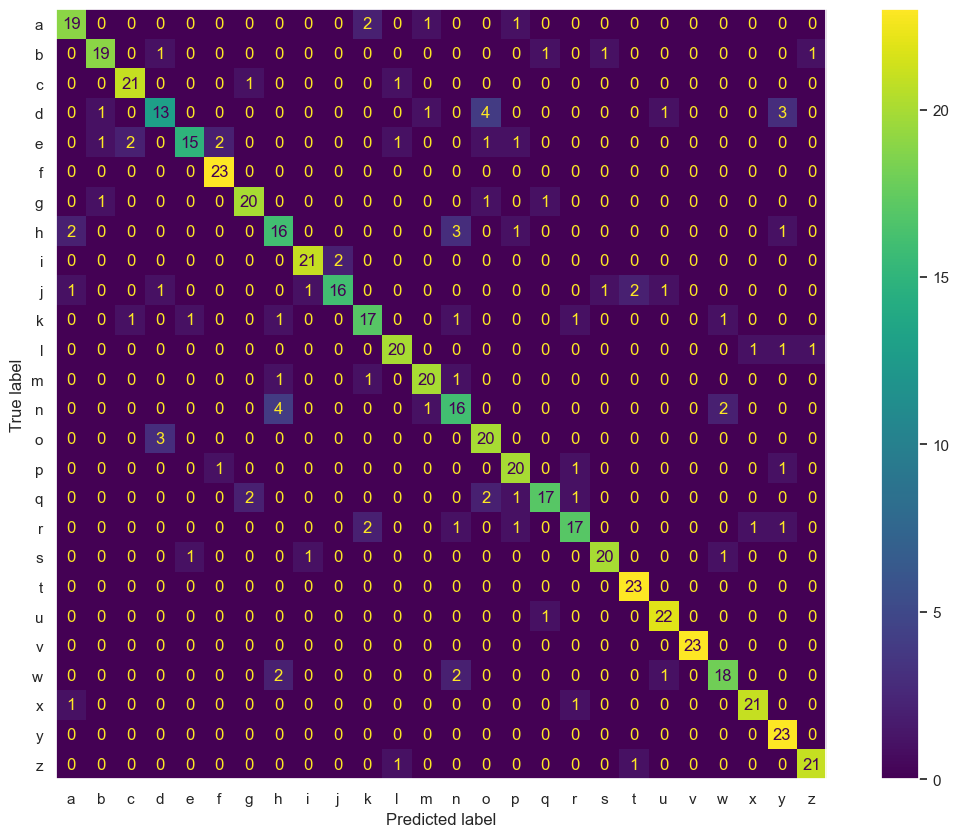

In [ ]:
evaluate_model(et, x_train, y_train, x_test, y_test)

### SVC

In [ ]:
svc = SVC(random_state=0)

temps de calcul 0.68 s
accuracy = 0.8578595317725752
f1_score = [0.84444444 0.93333333 0.875      0.7        0.80952381 0.95833333
 0.83333333 0.83333333 0.90909091 0.85106383 0.74509804 0.93877551
 0.83333333 0.84444444 0.875      0.85106383 0.8372093  0.73170732
 0.85714286 0.93877551 0.89795918 1.         0.8372093  0.86363636
 0.76923077 0.90909091]


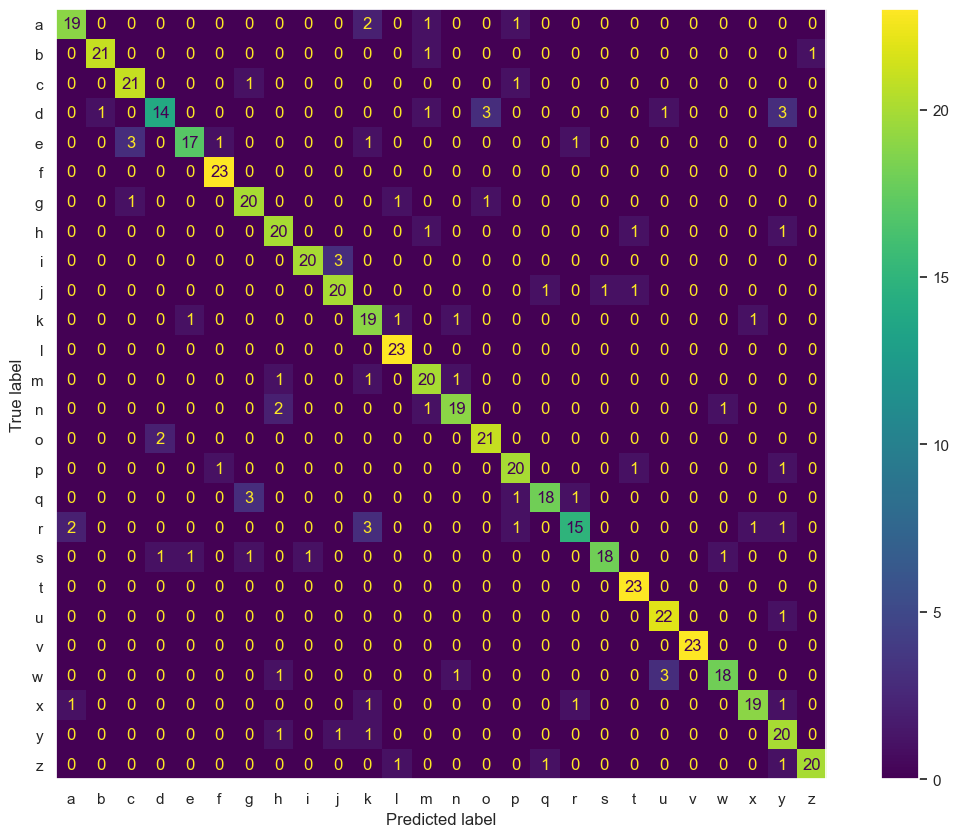

In [ ]:
evaluate_model(svc, x_train, y_train, x_test, y_test)

### Random Forest

In [ ]:
rf_defaut = RandomForestClassifier(random_state=0, n_jobs=n_jobs)

temps de calcul 0.28 s
accuracy = 0.822742474916388
f1_score = [0.7826087  0.82926829 0.93617021 0.55813953 0.71428571 0.95652174
 0.875      0.73469388 0.97777778 0.8        0.8        0.89361702
 0.79166667 0.66666667 0.80769231 0.85714286 0.75555556 0.65217391
 0.88888889 0.93877551 0.75555556 1.         0.8        0.9047619
 0.83018868 0.84444444]


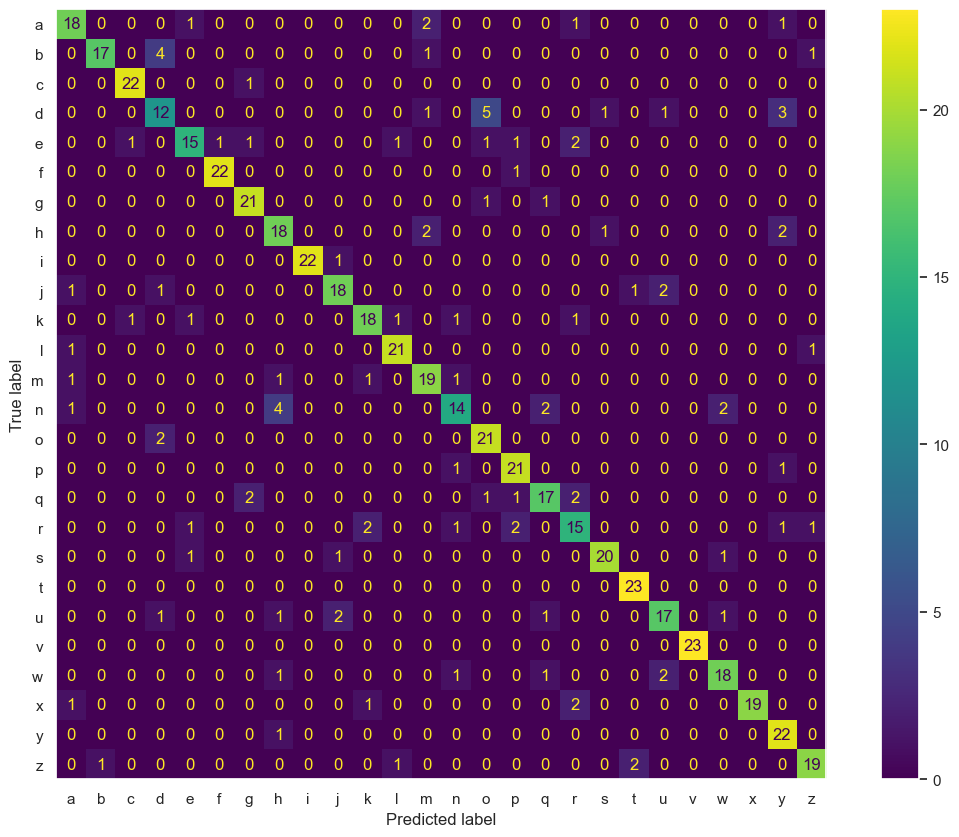

In [ ]:
evaluate_model(rf_defaut, x_train, y_train, x_test, y_test)

## Grid search sur Hyper paramètres

Nous effectuons une grid search avec cross-validation Stratified K Fold

In [ ]:
rf_tuning = RandomForestClassifier(random_state=0, n_jobs=n_jobs)

In [ ]:
model_params = {
    "max_depth": [None, 5, 10],
    "n_estimators": [100, 50],
}

clf = GridSearchCV(
    estimator=rf_tuning,
    param_grid=model_params,
    scoring=make_scorer(accuracy_score),
    n_jobs=n_jobs,
    verbose=1,
    cv=kfold,
)

clf.fit(
    x_train, y_train
)  # décommenter pour exécuter (peut durer des dizaines de minutes)
results = pd.DataFrame(clf.cv_results_)  # résultats détaillés de la CV
clf.best_estimator_  # notre meilleur modèle de RandomForest qu'on a obtenu

Fitting 10 folds for each of 6 candidates, totalling 60 fits


RandomForestClassifier(max_depth=10, n_jobs=-1, random_state=0)

In [ ]:
results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,1.524299,0.385475,0.386700,0.307839,None,100,"{'max_depth': None, 'n_estimators': 100}",0.829167,0.816667,0.828452,0.799163,0.828452,0.866109,0.820084,0.824268,0.811715,0.811715,0.823579,0.016809,2
1,0.701200,0.365067,0.414600,0.369329,None,50,"{'max_depth': None, 'n_estimators': 50}",0.804167,0.791667,0.828452,0.803347,0.807531,0.845188,0.820084,0.832636,0.811715,0.803347,0.814813,0.015584,3
2,0.786596,0.110704,0.209700,0.112995,5,100,"{'max_depth': 5, 'n_estimators': 100}",0.700000,0.679167,0.690377,0.686192,0.694561,0.673640,0.702929,0.677824,0.711297,0.669456,0.688544,0.013001,5
3,0.457101,0.079189,0.148299,0.066972,5,50,"{'max_depth': 5, 'n_estimators': 50}",0.691667,0.666667,0.677824,0.686192,0.698745,0.669456,0.682008,0.690377,0.711297,0.669456,0.684369,0.013532,6
4,1.171899,0.373701,0.559300,0.248323,10,100,"{'max_depth': 10, 'n_estimators': 100}",0.829167,0.820833,0.845188,0.820084,0.836820,0.836820,0.811715,0.832636,0.807531,0.836820,0.827762,0.011616,1
5,0.658100,0.359544,0.185600,0.124371,10,50,"{'max_depth': 10, 'n_estimators': 50}",0.783333,0.795833,0.841004,0.807531,0.811715,0.811715,0.782427,0.815900,0.803347,0.807531,0.806034,0.016041,4


In [ ]:
print("Voici les meilleurs paramètres")
print(f"{clf.best_estimator_.max_depth = },\n{clf.best_estimator_.n_estimators = }")

Voici les meilleurs paramètres
clf.best_estimator_.max_depth = 10,
clf.best_estimator_.n_estimators = 100


Le meilleur modèle est le même que celui par défaut.

# Save models


In [ ]:
save_model(et, x_train, model_name="extra-trees")
save_model(rf_defaut, x_train, model_name="random-forest")
save_model(svc, x_train, model_name="svc")